In [100]:
filepath='sample_data_SP500.csv'
field='ROE'#value given is assumed to be end of the month
ticker='ID'
date='DATE'
price='PRCCD'#raw price at end of the month
ret='FRTN1P'#1-period forward adjusted return
pricingTRfield='FwdTotalReturn1Period' # computed field, not in original data... can be changed to PRCCD for ex-dividend returns
NUMQUANTILES=20
NUMSECTORBINS=5
DELAY=1 # based on an ROE value on date di, the earliest you can trade is at the price on di+delay
FLT_ZSCORE=20

In [101]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1500)

import os
import glob
import ntpath
from datetime import datetime
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import scipy
from statsmodels import regression
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
import seaborn as sns
#%matplotlib inline

%pylab inline --no-import-all
import alphalens as alphadetail
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [102]:
# Generic mask function and sample call
def mask(df, f):
    return df[f(df)]   

# Daily Return Function
def dailyRet(df):
    return df.groupby([ticker])['TotalReturn'].transform(lambda x: x.pct_change(1))

# Lag-N cross correlation between two pandas series
def crosscorr(datax,datay,lag=0):
    return datax.corr(datay.shift(lag))

# Regression Function
def regress(data, y, x):
 Y = data[y]; X = data[x]
 X['intercept'] = 1
 result = sm.OLS(Y, X).fit()
 return result.params

#compute the 5% and 95% quantiles for each column in a group and clip values outside this quantile range.
def winsorize_series(s):
    q = s.quantile([0.01, 0.99])
    if isinstance(q, pd.Series) and len(q) == 2:
        s[s < q.iloc[0]] = q.iloc[0]
        s[s > q.iloc[1]] = q.iloc[1]
    return s

def winsorize_df(df):
    return df.apply(winsorize_series)


<b>We are backtesting whether the ROE field in period di is indicative of the future excess return of the security over subsequent period [di, di+1]<b>

In [103]:
df = pd.read_csv(filepath,usecols=["ID", "DATE", "ROE","RTN1M","PRCCD", "CUM_DIV", "QES_GSECTOR", "FRTN1P"],delimiter=',',parse_dates=['DATE'])

In [104]:
sortedDates = numpy.sort(df[date].dt.date.unique(), axis=0)


In [105]:
# obvious outliers
df[abs(df['ROE'])>1e+5 ].head()

,ID,DATE,ROE,RTN1M,PRCCD,CUM_DIV,QES_GSECTOR,FRTN1P
3,1161.01,2017-01-31,-2.740000e+12,-0.085538,10.37,0.0050,45.0,0.394407
78,4094.01,2017-01-31,5.050000e+11,0.010715,122.62,205.7660,20.0,-0.135194
145,6733.01,2017-01-31,5.810000e+12,-0.085510,60.21,35.0607,25.0,-0.116094
271,12441.01,2017-01-31,9.640000e+11,-0.016919,99.36,1.1945,45.0,0.038748
308,17928.01,2017-01-31,2.060000e+12,0.032084,78.49,0.0000,35.0,-0.014015


In [106]:
# field values are as of end of the date period, ie first value is as of 2017-01-31 
# and corresponding FRTN1P is the forward return over the subsequent period 2017-02-01 to 2017-2-28
# 
# Since we dont have forward returns for the last month, we delete the rows from the analysis
#df = df[~pd.isnull(df['FRTN1P'])]

#filter insanely high ROE values - this could be replaced by normalization or standardization, 
# but the filter is a first no brainer cut
df = df[abs(df['ROE'])<1e+5]


In [107]:
#set index to (ticker,date) tuple
dfwt=df[pd.notnull(df[field])].set_index([ticker,date]).sort_index()[["ROE","RTN1M","PRCCD", "CUM_DIV", "QES_GSECTOR", "FRTN1P"]]

# Assuming starting value of 1 for each ticker as of Jan 1, 2017: 
# calculate cumulative return series 'FwdTotalReturn1Period' using the forward returns column

dfwtNew=dfwt.reset_index()
dfwtNew['FRTN1P']=1+dfwtNew['FRTN1P']
dfwtNew['FwdTotalReturn1Period'] = dfwtNew.groupby('ID')['FRTN1P'].cumprod().shift(1)
dfwt.reset_index(inplace=True)
dfwt['FwdTotalReturn1Period'] = dfwtNew['FwdTotalReturn1Period'].astype(float)
dfwt.set_index([ticker,date],inplace=True)
dfwt['FwdTotalReturn1Period'].fillna(1.0, inplace=True)
dfwt.head(20)



ROE     RTN1M  PRCCD  CUM_DIV  QES_GSECTOR  \
ID      DATE                                                           
1045.04 2017-01-31  65.644548 -0.052260  44.25    1.000         20.0   
        2017-02-28  65.644548 -0.010437  46.36    1.100         20.0   
        2017-03-31  65.644548 -0.101720  42.30    1.100         20.0   
        2017-04-30  46.921444  0.015729  42.62    1.100         20.0   
        2017-05-31  46.921444  0.152804  48.41    1.200         20.0   
        2017-06-30  46.921444  0.039455  50.32    1.200         20.0   
        2017-07-31  50.520387  0.002385  50.44    1.200         20.0   
        2017-08-31  50.520387 -0.121817  44.74    1.300         20.0   
        2017-09-30  50.520387  0.071525  47.49    1.300         20.0   
        2017-10-31  48.586022 -0.014108  46.82    1.300         20.0   
        2017-11-30  48.586022  0.080521  50.49    1.400         20.0   
1075.01 2017-01-31   9.721892  0.003268  77.63   56.230         55.0   
        2017-02-28   9.434848  0.079132  82.19   56.230         55.0   
        2017-03-31   9.434848  0.011893  83.38   56.230         55.0   
        2017-04-30   9.434848  0.026640  85.09   56.885         55.0   
        2017-05-31   9.950650  0.051035  88.35   56.885         55.0   
        2017-06-30   9.950650 -0.036106  85.16   56.885         55.0   
        2017-07-31   9.950650  0.026127  86.73   57.540         55.0   
        2017-08-31  10.848998  0.032595  89.97   57.540         55.0   
        2017-09-30  10.848998 -0.060340  84.56   57.540         55.0   

                      FRTN1P  FwdTotalReturn1Period  
ID      DATE                                         
1045.04 2017-01-31  0.049944               1.000000  
        2017-02-28 -0.087575               1.049944  
        2017-03-31  0.007565               0.957994  
        2017-04-30  0.138198               0.965241  
        2017-05-31  0.039455               1.098636  
        2017-06-30  0.002385               1.141982  
        2017-07-31 -0.111023               1.144706  
        2017-08-31  0.061466               1.017617  
        2017-09-30 -0.014108               1.080166  
        2017-10-31  0.080521               1.064927  
        2017-11-30       NaN               1.150676  
1075.01 2017-01-31  0.058740               1.000000  
        2017-02-28  0.014479               1.058740  
        2017-03-31  0.028364               1.074069  
        2017-04-30  0.038312               1.104534  
        2017-05-31 -0.036106               1.146852  
        2017-06-30  0.026127               1.105443  
        2017-07-31  0.037357               1.134325  
        2017-08-31 -0.060131               1.176701  
        2017-09-30  0.045471               1.105944

In [108]:
dfwt[field + '_quantile_alldi']=pd.qcut(dfwt[field],NUMQUANTILES,labels=False)+1
dfwt.head(20)

ROE     RTN1M  PRCCD  CUM_DIV  QES_GSECTOR  \
ID      DATE                                                           
1045.04 2017-01-31  65.644548 -0.052260  44.25    1.000         20.0   
        2017-02-28  65.644548 -0.010437  46.36    1.100         20.0   
        2017-03-31  65.644548 -0.101720  42.30    1.100         20.0   
        2017-04-30  46.921444  0.015729  42.62    1.100         20.0   
        2017-05-31  46.921444  0.152804  48.41    1.200         20.0   
        2017-06-30  46.921444  0.039455  50.32    1.200         20.0   
        2017-07-31  50.520387  0.002385  50.44    1.200         20.0   
        2017-08-31  50.520387 -0.121817  44.74    1.300         20.0   
        2017-09-30  50.520387  0.071525  47.49    1.300         20.0   
        2017-10-31  48.586022 -0.014108  46.82    1.300         20.0   
        2017-11-30  48.586022  0.080521  50.49    1.400         20.0   
1075.01 2017-01-31   9.721892  0.003268  77.63   56.230         55.0   
        2017-02-28   9.434848  0.079132  82.19   56.230         55.0   
        2017-03-31   9.434848  0.011893  83.38   56.230         55.0   
        2017-04-30   9.434848  0.026640  85.09   56.885         55.0   
        2017-05-31   9.950650  0.051035  88.35   56.885         55.0   
        2017-06-30   9.950650 -0.036106  85.16   56.885         55.0   
        2017-07-31   9.950650  0.026127  86.73   57.540         55.0   
        2017-08-31  10.848998  0.032595  89.97   57.540         55.0   
        2017-09-30  10.848998 -0.060340  84.56   57.540         55.0   

                      FRTN1P  FwdTotalReturn1Period  ROE_quantile_alldi  
ID      DATE                                                             
1045.04 2017-01-31  0.049944               1.000000                  19  
        2017-02-28 -0.087575               1.049944                  19  
        2017-03-31  0.007565               0.957994                  19  
        2017-04-30  0.138198               0.965241                  19  
        2017-05-31  0.039455               1.098636                  19  
        2017-06-30  0.002385               1.141982                  19  
        2017-07-31 -0.111023               1.144706                  19  
        2017-08-31  0.061466               1.017617                  19  
        2017-09-30 -0.014108               1.080166                  19  
        2017-10-31  0.080521               1.064927                  19  
        2017-11-30       NaN               1.150676                  19  
1075.01 2017-01-31  0.058740               1.000000                   7  
        2017-02-28  0.014479               1.058740                   7  
        2017-03-31  0.028364               1.074069                   7  
        2017-04-30  0.038312               1.104534                   7  
        2017-05-31 -0.036106               1.146852                   7  
        2017-06-30  0.026127               1.105443                   7  
        2017-07-31  0.037357               1.134325                   7  
        2017-08-31 -0.060131               1.176701                   8  
        2017-09-30  0.045471               1.105944                   8

In [109]:
sector_namesint = {25: 0,
                30: 1,
                10: 2,
                40: 3,
                35: 4,
                20: 5,
                45: 6,
                15: 7,
                50: 8,
                55: 9}
dfwt = dfwt[np.isfinite(dfwt['QES_GSECTOR'])]
dfwt['QES_GSECTOR'].replace([np.inf, -np.inf], np.nan)
dfwt = dfwt.dropna(subset=['QES_GSECTOR'])

dfwt['iSector'] = dfwt['QES_GSECTOR'].map(sector_namesint)
dfwt = dfwt[dfwt['iSector'].isin([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0])]

dfwt = dfwt.reset_index().dropna().drop_duplicates()
dfwt.head()

,ID,DATE,ROE,RTN1M,PRCCD,CUM_DIV,QES_GSECTOR,FRTN1P,FwdTotalReturn1Period,ROE_quantile_alldi,iSector
0,1045.04,2017-01-31,65.644548,-0.052260,44.25,1.0,20.0,0.049944,1.000000,19,5.0
1,1045.04,2017-02-28,65.644548,-0.010437,46.36,1.1,20.0,-0.087575,1.049944,19,5.0
2,1045.04,2017-03-31,65.644548,-0.101720,42.30,1.1,20.0,0.007565,0.957994,19,5.0
3,1045.04,2017-04-30,46.921444,0.015729,42.62,1.1,20.0,0.138198,0.965241,19,5.0
4,1045.04,2017-05-31,46.921444,0.152804,48.41,1.2,20.0,0.039455,1.098636,19,5.0


In [110]:
dfticker_sector = dfwt.dropna()[[ticker, 'iSector']]
sector_namesStr = {25: 'Consumer Discretionary',
                30: 'Consumer Staples',
                10: 'Energy',
                40: 'Financials',
                35: 'Health Care',
                20: 'Industrials',
                45: 'Information Technology',
                15: 'Materials',
                50: 'Telecommunications Services',
                55: 'Utilities'}
sector_names = {0: 'Consumer Discretionary',
                1: 'Consumer Staples',
                2: 'Energy',
                3: 'Financials',
                4: 'Health Care',
                5: 'Industrials',
                6: 'Information Technology',
                7: 'Materials',
                8: 'Telecommunications Services',
                9: 'Utilities'}
uniq_dfticker_sector = dfticker_sector.dropna().drop_duplicates(subset=[ticker, 'iSector']).drop_duplicates(subset=[ticker]).rename(columns={ticker: 'asset'})
ticker_sector = uniq_dfticker_sector.set_index('asset').T.to_dict('records')[0]


In [111]:
dfpredictive_factor = dfwt.reset_index().dropna()[[date,ticker,field]].rename(columns={date: 'date', ticker: 'asset', field:'factor'})
uniq_dfpredictive_factor = dfpredictive_factor.dropna().drop_duplicates(subset=['date', 'asset'])
uniq_dfpredictive_factor['date'].dt.date.unique()

array([datetime.date(2017, 1, 31), datetime.date(2017, 2, 28),
       datetime.date(2017, 3, 31), datetime.date(2017, 4, 30),
       datetime.date(2017, 5, 31), datetime.date(2017, 6, 30),
       datetime.date(2017, 7, 31), datetime.date(2017, 8, 31),
       datetime.date(2017, 9, 30), datetime.date(2017, 10, 31)],
      dtype=object)

In [112]:
#normalize or standardize
from sklearn.preprocessing import minmax_scale
from sklearn import preprocessing,decomposition, linear_model, pipeline, metrics
from sklearn_pandas import DataFrameMapper, cross_val_score

for di in uniq_dfpredictive_factor['date'].dt.date.unique():
    dfdi = uniq_dfpredictive_factor[uniq_dfpredictive_factor['date'] == di][['date', 'asset','factor']]
    
    mapper_df = DataFrameMapper([
        (['factor'],  preprocessing.StandardScaler(),{'alias': 'factornorm'})
    ], df_out=True, default=None) #df_out returns dataframe and default None lets pass unmapped columns unchanged
    
    dfdi_normalized_scaled = mapper_df.fit_transform(dfdi.copy()) 
    uniq_dfpredictive_factor.loc[uniq_dfpredictive_factor.date == di,'factornorm'] = dfdi_normalized_scaled

print(uniq_dfpredictive_factor[abs(uniq_dfpredictive_factor['factornorm'])>3])
uniq_dfpredictive_factor['factornorm'] = uniq_dfpredictive_factor['factornorm'].apply(lambda x: x if x <= 3 else 3)
uniq_dfpredictive_factor['factornorm'] = uniq_dfpredictive_factor['factornorm'].apply(lambda x: x if x >= -3 else -3)

print(uniq_dfpredictive_factor[abs(uniq_dfpredictive_factor['factornorm'])==3])

predictive_factor = uniq_dfpredictive_factor[uniq_dfpredictive_factor.asset.isin(uniq_dfticker_sector.asset)].dropna().pivot(index='date', columns='asset', values='factornorm')
predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])



           date      asset        factor  factornorm
30   2017-02-28    1161.01  -2028.571429   -4.891589
31   2017-03-31    1161.01  -2028.571429   -4.886274
32   2017-04-30    1161.01  -2028.571429   -4.883489
33   2017-05-31    1161.01 -23050.000000  -21.676462
34   2017-06-30    1161.01 -23050.000000  -21.699210
35   2017-10-31    1161.01  -3450.000000  -13.920160
477  2017-01-31    3121.01    315.180723    5.164118
497  2017-01-31    3170.01    632.273839   10.785042
500  2017-10-31    3170.01   4014.754098   15.987827
1325 2017-01-31    6435.01    536.638452    9.089770
1328 2017-04-30    6435.01   2845.859873    6.614130
1465 2017-01-31    7085.01    511.442786    8.643141
1468 2017-07-31    7085.01   4584.000000   20.996435
1469 2017-08-31    7085.01   4584.000000   20.999174
1470 2017-09-30    7085.01   4584.000000   20.999198
1471 2017-10-31    7085.01    838.571429    3.262260
1501 2017-01-31    7163.01    312.096774    5.109451
1922 2017-01-31    8606.01    205.716993    3.

In [113]:
dfpricing = dfwt.reset_index().dropna()[[date,ticker,pricingTRfield]].rename(columns={date: 'Date', ticker: 'asset', pricingTRfield:'Open'})
uniq_dfpricing = dfpricing.dropna().drop_duplicates(subset=['Date', 'asset'])
pricing = uniq_dfpricing[uniq_dfpricing.asset.isin(uniq_dfticker_sector.asset)].dropna().pivot(index='Date', columns='asset', values='Open')
pricing.head()

asset,1045.04,1075.01,1078.01,1161.01,1177.01,1209.01,1230.01,1300.01,1327.01,1380.01,1440.01,1447.01,1449.01,1487.01,1598.01,1602.01,1632.01,1678.01,1690.01,1704.01,1722.01,1878.01,1891.01,1913.01,1976.01,1988.01,2019.01,2044.01,2086.01,2111.01,2136.01,2176.02,2184.01,2269.01,2285.01,2312.01,2403.01,2435.01,2547.01,2574.01,2663.01,2710.02,2751.01,2817.01,2884.01,2968.01,2991.01,3026.01,3062.01,3121.01,...,149070.01,149318.01,149337.01,150699.01,150937.01,155394.02,157057.01,157855.01,160225.01,160329.01,160329.03,162129.01,162906.01,163610.01,163946.01,164296.01,164296.03,164708.01,165052.01,165052.03,165675.01,165914.01,165993.01,170617.01,170841.01,174729.01,175263.01,175319.01,175404.01,176282.01,177267.02,177376.02,177884.01,178310.01,178704.01,179437.01,179534.01,179700.01,180167.01,180405.01,180652.01,180711.01,184500.01,186989.01,188255.01,189491.01,198058.01,199356.01,294524.01,316056.01
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-31,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.093663,1.612609,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2017-02-28,1.049944,1.058740,1.079243,1.000000,1.085575,1.005080,1.045832,1.057852,1.033464,0.949428,1.054636,1.048180,1.039863,0.994709,1.056164,1.134031,1.099279,0.879137,1.133581,1.060438,1.068459,1.060979,1.016140,1.110929,0.958307,0.965906,1.053879,1.033329,1.062826,1.032489,1.012650,1.044352,0.991240,0.958062,1.111553,1.030174,1.153580,1.069298,1.018329,1.050657,0.953720,1.063101,1.085512,1.010454,0.938128,1.070779,1.020027,1.106369,1.016364,1.140083,...,1.003138,NaN,1.008081,0.930405,1.067331,0.989658,1.024709,1.028445,1.038841,1.030164,1.033158,1.003028,1.008872,0.978924,0.898838,1.014462,1.012992,1.177964,0.959516,0.965661,1.031087,0.993593,1.035885,1.040055,0.965695,1.052871,1.003064,0.850274,1.160308,0.990074,1.006590,1.031178,0.949871,1.059264,1.004224,1.067198,1.065228,1.024561,1.064470,1.122358,1.003388,1.057293,0.980281,1.039750,1.052240,0.979517,0.852605,0.783932,0.978235,1.105375
2017-03-31,0.957994,1.074069,1.063203,1.006224,1.075373,0.974814,0.985961,1.060995,1.068018,0.894426,1.057156,1.035742,1.040869,0.976502,1.060078,1.053988,1.099548,0.859077,1.188774,1.138902,1.047304,1.063069,1.019507,1.109414,0.950994,0.975496,1.055891,1.047234,1.085160,1.038806,0.994695,1.015475,1.111635,NaN,1.090769,1.042774,1.106184,1.016721,1.002120,1.007169,0.919814,1.084924,1.093902,0.969684,0.932328,1.037930,0.973514,1.107035,1.089829,1.123583,...,0.986620,NaN,0.989084,0.884299,1.031229,0.917267,0.990242,1.042857,1.057745,1.033663,1.041128,0.938389,1.063371,1.029301,0.839621,1.026102,1.021653,1.161660,0.920428,0.952133,1.111058,1.057137,1.006170,1.090009,0.978416,1.073488,1.048264,0.882143,0.868868,0.990074,1.007672,0.991316,0.920396,1.059946,1.047561,1.064051,1.076493,1.080044,1.032840,1.247451,0.981849,1.102657,1.021351,1.059455,1.107190,1.022264,0.890213,0.815879,0.986812,1.155170
2017-04-30,0.965241,1.104534,1.051113,0.919779,1.142990,1.012354,0.909731,1.114270,1.087203,0.905929,1.068179,1.041765,1.076226,0.952727,1.121237,1.049170,1.022398,0.817285,1.188691,1.188967,1.040707,1.107327,1.040417,1.145340,0.943840,1.010044,1.056338,1.296676,1

In [114]:
#find forward returns for 1period(one could 2periods and 3periods by setting periods=(1,2,3) and the sector, quantile 
# in one dataframe
# FLT_ZSCORE deletes off price movements that are more than 20 std. deviations away from mean, but is set to None for time being
factor_data = alphadetail.utils.get_clean_factor_and_forward_returns(predictive_factor, 
                                                                   pricing, 
                                                                   quantiles=NUMQUANTILES,
                                                                   bins=None,
                                                                   groupby=ticker_sector,
                                                                   groupby_labels=sector_names,
                                                                   periods=([1]),
                                                                   by_group=False,
                                                                   filter_zscore=None)

In [115]:
factor_data.head()

1    factor        group  factor_quantile
date       asset                                                    
2017-01-31 1045.04  0.049944  0.740736  Industrials               19
           1075.01  0.058740 -0.250572    Utilities                7
           1078.01  0.079243 -0.332328  Health Care                4
           1177.01  0.085575 -0.189557  Health Care                9
           1209.01  0.005080 -0.078520    Materials               13

In [116]:
factor_dataq = factor_data[factor_data['factor_quantile'].isin([1,NUMQUANTILES])]
factor_dataq.head(20)

1    factor                   group  \
date       asset                                                 
2017-01-31 1380.01 -0.050572 -0.920645                  Energy   
           1678.01 -0.120863 -1.624772                  Energy   
           1878.01  0.060979 -0.911756  Information Technology   
           1976.01 -0.041693 -0.738432                  Energy   
           2285.01  0.016358  1.519144             Industrials   
           3121.01  0.140083  3.000000        Consumer Staples   
           3170.01  0.130071  3.000000        Consumer Staples   
           5439.01 -0.051794 -1.234049                  Energy   
           5597.01  0.033166  1.042856        Consumer Staples   
           5680.01  0.053278  1.358312  Consumer Discretionary   
           6066.01  0.038391  0.952456  Information Technology   
           6304.01  0.065210  2.422909  Information Technology   
           6435.01  0.094279  3.000000        Consumer Staples   
           6774.01  0.067919  2.114848             Industrials   
           6788.01 -0.145949 -0.835535                  Energy   
           7085.01  0.025190  3.000000             Industrials   
           7154.01  0.049115  2.062244  Consumer Discretionary   
           7163.01 -0.221562  3.000000              Financials   
           7912.01 -0.081740 -0.892798                  Energy   
           8068.01 -0.032758 -0.815067                  Energy   

                    factor_quantile  
date       asset                     
2017-01-31 1380.01                1  
           1678.01                1  
           1878.01                1  
           1976.01                1  
           2285.01               20  
           3121.01               20  
           3170.01               20  
           5439.01                1  
           5597.01               20  
           5680.01               20  
           6066.01               20  
           6304.01               20  
           6435.01               20  
           6774.01               20  
           6788.01                1  
           7085.01               20  
           7154.01               20  
           7163.01               20  
           7912.01                1  
           8068.01                1

# Pie chart of sector exposure

In [117]:
factor_data.loc[['2017-09-30','']]
sector_plot = factor_data.loc[['2017-09-30','']].groupby(['group'])['factor'].sum()
sector_plot


group
Consumer Discretionary        -2.531437
Consumer Staples               3.084390
Energy                        -8.242101
Financials                    -4.742827
Health Care                   -4.017224
Industrials                    2.891982
Information Technology        -2.828253
Materials                     -1.481112
Telecommunications Services   -0.429320
Utilities                     -3.496824
Name: factor, dtype: float64

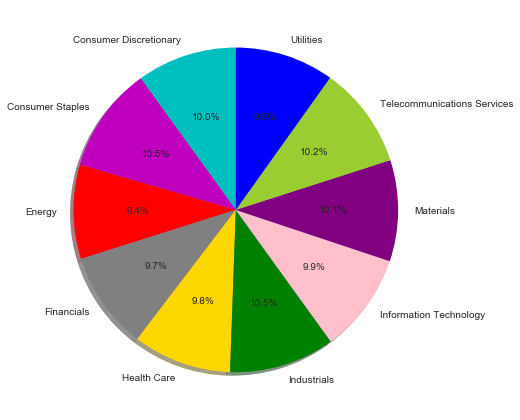

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import table
from matplotlib import cm

plt.figure(figsize=(16,8))
# plot chart

ax1 = plt.subplot(121, aspect='equal')
cols=['c','m','r','grey','gold','green','pink','purple','yellowgreen','blue']
plt.pie(1+((sector_plot.get_values())/100),labels=sector_plot.index,colors=cols,autopct='%1.1f%%', startangle=90, shadow=True)

plt.show()


# SUMMARY USING ONLY TOP AND BOTTOM QUANTILE

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-3.00000,0.014132,-0.368904,0.602893,217,50.115473
20,0.06818,3.000000,0.732151,0.877298,216,49.884527


Returns Analysis


,1
Ann. alpha,52.359
beta,-1.000
Mean Period Wise Return Top Quantile (bps),149.301
Mean Period Wise Return Bottom Quantile (bps),-148.613
Mean Period Wise Spread (bps),298.598


Information Analysis


,1
IC Mean,0.235
IC Std.,0.237
t-stat(IC),2.966
p-value(IC),0.018
IC Skew,-0.020
IC Kurtosis,-1.326
Ann. IR,15.695


Turnover Analysis


,1
Quantile 1 Mean Turnover,0.103
Quantile 2 Mean Turnover,NaN
Quantile 3 Mean Turnover,NaN
Quantile 4 Mean Turnover,NaN
Quantile 5 Mean Turnover,NaN
Quantile 6 Mean Turnover,NaN
Quantile 7 Mean Turnover,NaN
Quantile 8 Mean Turnover,NaN
Quantile 9 Mean Turnover,NaN
Quantile 10 Mean Turnover,NaN


,1
Mean Factor Rank Autocorrelation,0.98


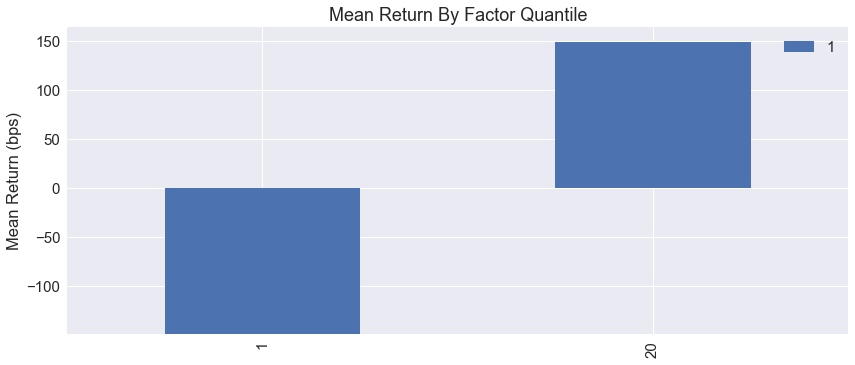

In [119]:
alphadetail.tears.create_summary_tear_sheet(factor_dataq)

# FULL SUMMARY USING ONLY TOP AND BOTTOM QUANTILE

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-3.00000,0.014132,-0.368904,0.602893,217,50.115473
20,0.06818,3.000000,0.732151,0.877298,216,49.884527


Returns Analysis


,1
Ann. alpha,52.359
beta,-1.000
Mean Period Wise Return Top Quantile (bps),149.301
Mean Period Wise Return Bottom Quantile (bps),-148.613
Mean Period Wise Spread (bps),298.598


Information Analysis


,1
IC Mean,0.235
IC Std.,0.237
t-stat(IC),2.966
p-value(IC),0.018
IC Skew,-0.020
IC Kurtosis,-1.326
Ann. IR,15.695


Turnover Analysis


,1
Quantile 1 Mean Turnover,0.103
Quantile 2 Mean Turnover,NaN
Quantile 3 Mean Turnover,NaN
Quantile 4 Mean Turnover,NaN
Quantile 5 Mean Turnover,NaN
Quantile 6 Mean Turnover,NaN
Quantile 7 Mean Turnover,NaN
Quantile 8 Mean Turnover,NaN
Quantile 9 Mean Turnover,NaN
Quantile 10 Mean Turnover,NaN


,1
Mean Factor Rank Autocorrelation,0.98


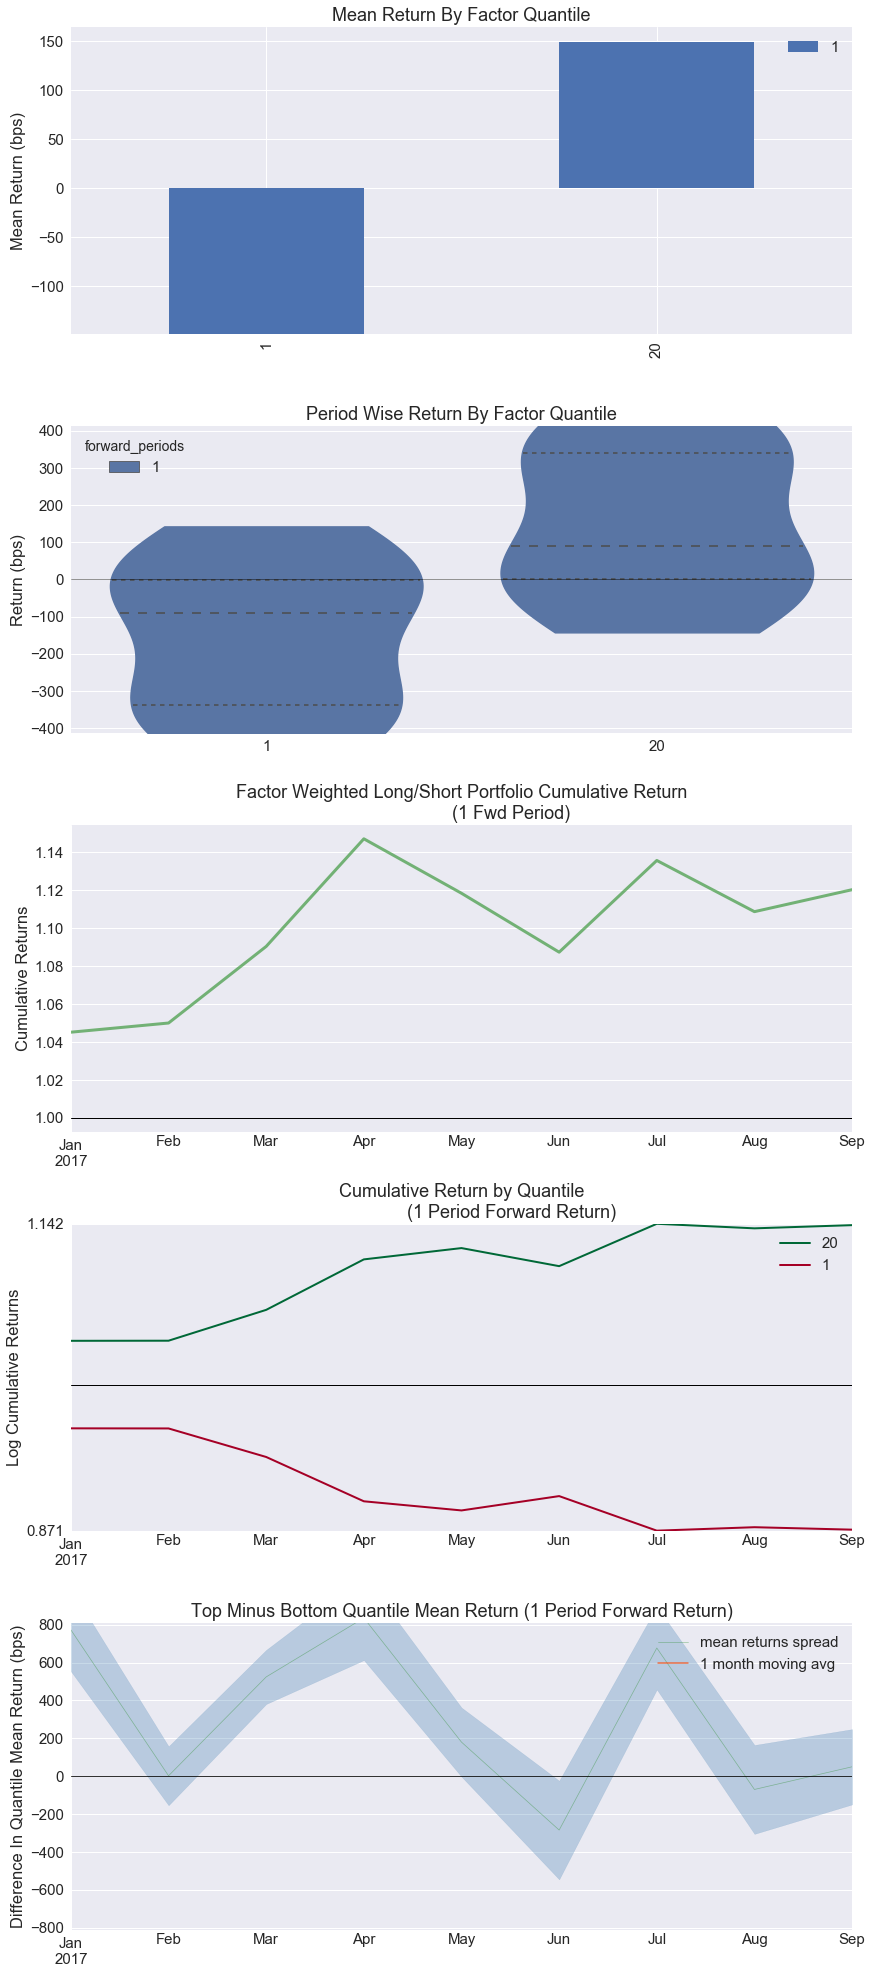

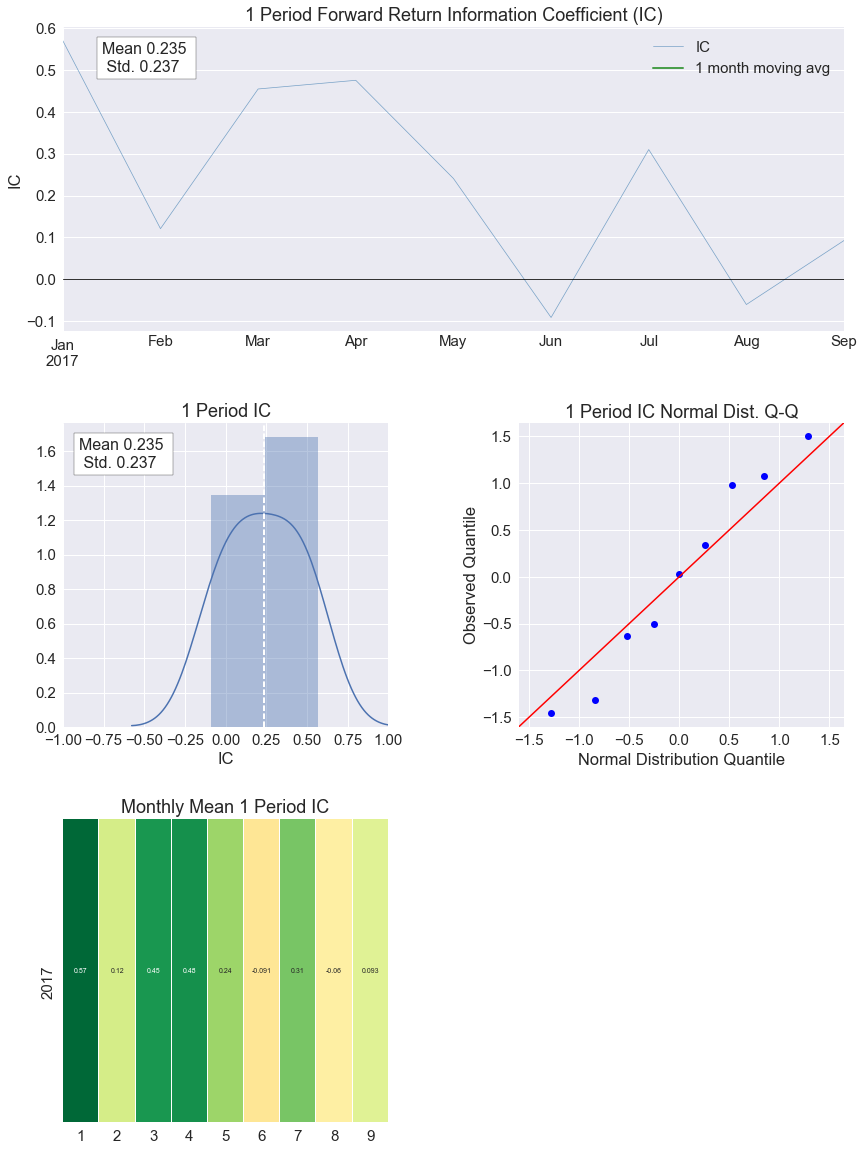

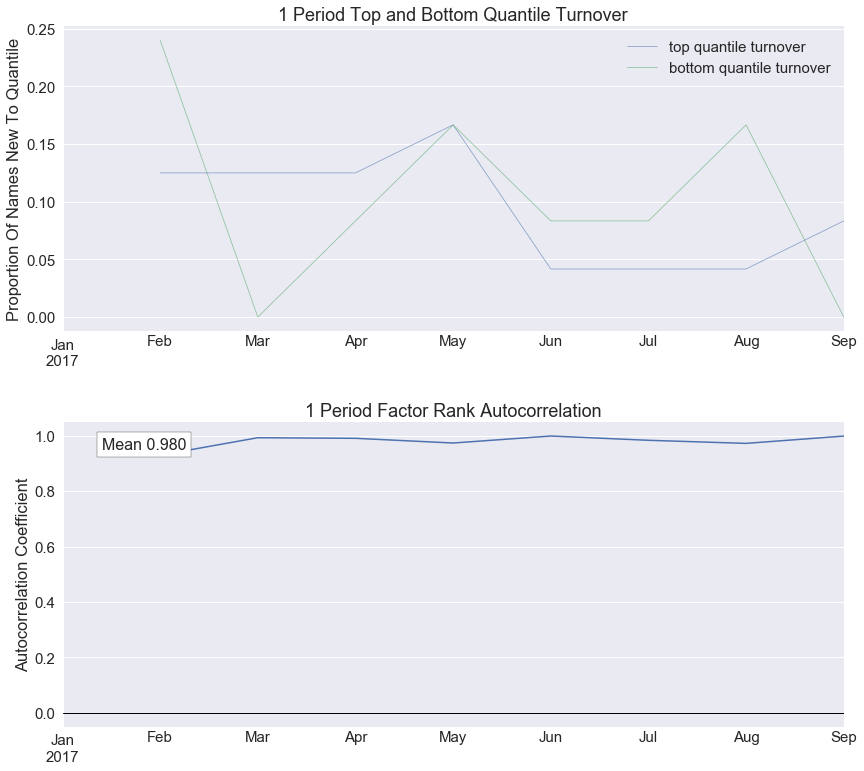

In [ ]:
alphadetail.tears.create_full_tear_sheet(factor_dataq)

# FULL SUMMARY USING ALL QUANTILES

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-3.000000,0.014132,-0.368904,0.602893,217,5.034803
2,-0.589099,0.019348,-0.141952,0.142082,216,5.011601
3,-0.416331,0.023968,-0.114747,0.110924,216,5.011601
4,-0.343933,0.025602,-0.101042,0.096428,216,5.011601
5,-0.302216,0.026912,-0.092814,0.086937,216,5.011601
6,-0.271768,0.028299,-0.087026,0.081617,215,4.988399
7,-0.253994,0.029324,-0.081106,0.076562,213,4.941995
8,-0.234499,0.030563,-0.077194,0.072480,216,5.011601
9,-0.214114,0.032097,-0.070907,0.065984,216,5.011601


Returns Analysis


,1
Ann. alpha,20.665
beta,-0.569
Mean Period Wise Return Top Quantile (bps),63.990
Mean Period Wise Return Bottom Quantile (bps),-233.668
Mean Period Wise Spread (bps),298.598


Information Analysis


,1
IC Mean,0.057
IC Std.,0.101
t-stat(IC),1.692
p-value(IC),0.129
IC Skew,-0.620
IC Kurtosis,-0.838
Ann. IR,8.952


Turnover Analysis


,1
Quantile 1 Mean Turnover,0.103
Quantile 2 Mean Turnover,0.177
Quantile 3 Mean Turnover,0.198
Quantile 4 Mean Turnover,0.193
Quantile 5 Mean Turnover,0.224
Quantile 6 Mean Turnover,0.220
Quantile 7 Mean Turnover,0.240
Quantile 8 Mean Turnover,0.292
Quantile 9 Mean Turnover,0.276
Quantile 10 Mean Turnover,0.244


,1
Mean Factor Rank Autocorrelation,0.985


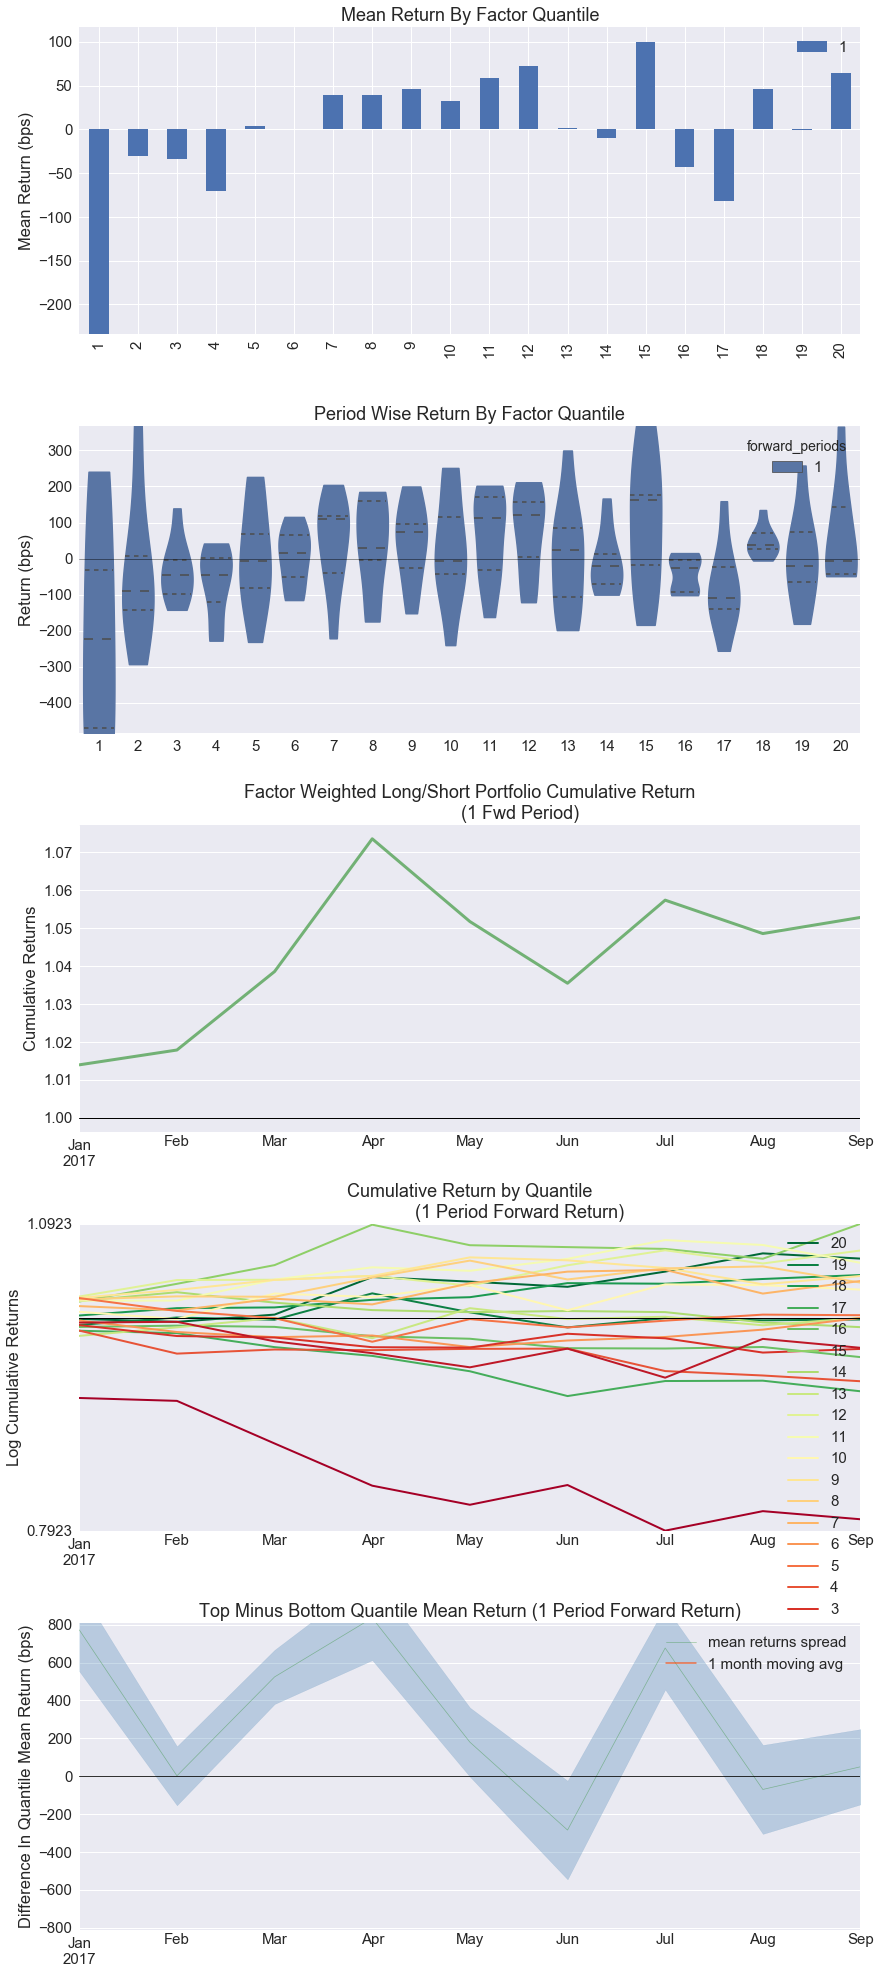

In [ ]:
alphadetail.tears.create_full_tear_sheet(factor_data)

# SET BY_GROUP to true and do quantiling at sector level

In [ ]:
#Find factor_data_sector but using by_group true
factor_data_sector = alphadetail.utils.get_clean_factor_and_forward_returns(predictive_factor, 
                                                                   pricing, 
                                                                   quantiles=None,
                                                                   bins=NUMSECTORBINS,
                                                                   groupby=ticker_sector,
                                                                   groupby_labels=sector_names,
                                                                   periods=([1]),
                                                                   by_group=True,
                                                                   filter_zscore=FLT_ZSCORE)

In [ ]:
factor_data_sector.head(10)

In [ ]:
factor_data_sectorq = factor_data_sector[factor_data_sector['factor_quantile'].isin([1,NUMSECTORBINS])]
factor_data_sectorq.head(20)

In [ ]:
# SUMMARY: ONLY BINS 1 and 5 in sectors

In [ ]:
alphadetail.tears.create_summary_tear_sheet(factor_data_sectorq)

In [ ]:
# DETAIL: ONLY BINS 1 and 5 in sectors

In [ ]:
alphadetail.tears.create_full_tear_sheet(factor_data_sectorq)

In [ ]:
# SUMMARY: ALL Sector Bins

In [ ]:
alphadetail.tears.create_summary_tear_sheet(factor_data_sector)

In [ ]:
# DETAIL: ALL Sector Bins

In [ ]:
alphadetail.tears.create_full_tear_sheet(factor_data_sector)